In [ ]:
import gym
import fh_ac_ai_gym

class KB_CNF:
    def __init__(self):
        self.clauses = set()  # store frozensets

    def TELL(self, clause):
        """
        Adds a clause (list/set of literals) to the KB.
        """
        f_clause = frozenset(clause)
        self.clauses.add(f_clause)

    def ASK(self, query):
        """
        Checks if the KB entails the query via resolution.
        """
        # Start with a copy of the KB
        clauses = set(self.clauses)

        # Negate the query
        negated_query = frozenset({self._negate(query)})
        clauses.add(negated_query)

        new = set()
        step = 0
        MAX_NEW_CLAUSES = 1000

        while True:
            pairs = [
                (ci, cj)
                for i, ci in enumerate(clauses)
                for j, cj in enumerate(clauses)
                if i < j
            ]

            for ci, cj in pairs:
                resolvents = self._resolve(ci, cj)
                for res in resolvents:
                    if not res:
                        return True
                    if res not in clauses and res not in new:
                        new.add(res)

            if not new:
                return False

            step += len(new)
            if step > MAX_NEW_CLAUSES:
                print(f"Resolution limit reached while proving {query}. Cannot conclude.")
                return False

            clauses.update(new)
            new.clear()

    def _negate(self, literal):
        """
        Negates a single literal string.
        """
        return literal[1:] if literal.startswith('-') else '-' + literal

    def _resolve(self, ci, cj):
        """
        Resolves two clauses (frozensets of literals).
        Returns a set of frozensets as resolvent clauses.
        """
        resolvents = set()
        for literal in ci:
            complementary = self._negate(literal)
            if complementary in cj:
                new_clause = (ci - {literal}) | (cj - {complementary})
                resolvents.add(frozenset(new_clause))
        return resolvents

class KB_Horn:
    def __init__(self):
        # Each rule is a dict with:
        #   "premise": set of literals
        #   "conclusion": single literal
        self.clauses = []
        self.facts = set()

    def TELL_fact(self, literal):
        self.facts.add(literal)

    def TELL_rule(self, premise_set, conclusion):
        self.clauses.append({
            "premise": set(premise_set),
            "conclusion": conclusion
        })

    def ASK(self, query):
        # Forward chaining
        agenda = list(self.facts)
        inferred = set(self.facts)

        # count how many premises remain for each clause
        count = {id(c): len(c["premise"]) for c in self.clauses}

        while agenda:
            p = agenda.pop(0)
            if p == query:
                return True
            for clause in self.clauses:
                if p in clause["premise"]:
                    count[id(clause)] -= 1
                    if count[id(clause)] == 0:
                        conclusion = clause["conclusion"]
                        if conclusion not in inferred:
                            inferred.add(conclusion)
                            agenda.append(conclusion)

        return False


In [ ]:

# ------------------------------------------------------------
# Create Wumpus environment
# ------------------------------------------------------------
wumpus_env = gym.make('Wumpus-v0', disable_env_checker=True)
wumpus_env.reset()

# ------------------------------------------------------------
# Create two separate KBs
# ------------------------------------------------------------
KB_wumpus = KB_CNF()
KB_pit = KB_CNF()
KB_gold = KB_CNF()

# ------------------------------------------------------------
# Step 1
# ------------------------------------------------------------
wumpus_env.step(1)
wumpus_env.render()

print("Step 1: Stench sensed at (1,1)")

# S11 <==> W12 OR W21
KB_wumpus.TELL(["-W21", "S11"])
KB_wumpus.TELL(["-W12", "S11"])
KB_wumpus.TELL(["-S11", "W21", "W12"])
# Fact: Stench sensed at (1,1), no Wumpus and no Pit in (1,1)
KB_wumpus.TELL(["S11"])
KB_wumpus.TELL(["-W11"])
KB_pit.TELL(["-P11"])

print("Wumpus at (1,2)?")
print(KB_wumpus.ASK("W12")) # initially false

print("Wumpus at (2,1)?")
print(KB_wumpus.ASK("W21")) # initially false

# ------------------------------------------------------------
# Step 2
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 2: No Wumpus in (1,2), OK")

# Fact: No Wumpus and no Pit in (1,2)
KB_wumpus.TELL(["-W12"])
KB_pit.TELL(["-P12"])

print("Wumpus at (1,2)?")
print(KB_wumpus.ASK("W12")) #false

print("Wumpus at (2,1)?")
print(KB_wumpus.ASK("W21")) #true

# ------------------------------------------------------------
# Step 3
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 3: Breeze sensed at (1,3), OK")

# P23 ↔ (B24 ∧ B22 ∧ B13 ∧ B33)
KB_pit.TELL(["-B24", "-B22", "-B13", "-B33", "P23"])
KB_pit.TELL(["-P23", "B24"])
KB_pit.TELL(["-P23", "B22"])
KB_pit.TELL(["-P23", "B13"])
KB_pit.TELL(["-P23", "B33"])

# Fact: Breeze sensed at (1,3), No Wumpus and no Pit in (1,3)
KB_pit.TELL(["B13"])
KB_wumpus.TELL(["-W13"])
KB_pit.TELL(["-P13"])

print("Pit at (2,3)?")
print(KB_pit.ASK("P23")) # initially false

# ------------------------------------------------------------
# Step 4
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 4: No Pit at (1,4), OK")

#Fact: No Pit at (1,4), no Wumpus at (1,4)
KB_pit.TELL(["-P14"])
KB_wumpus.TELL(["-W14"])

# ------------------------------------------------------------
# Step 5
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 5: Breeze sensed at (2,4), OK")

# Fact: Breeze sensed at (2,4), no Pit and no Wumpus at (2,4)
KB_pit.TELL(["B24"])
KB_pit.TELL(["-P24"])
KB_wumpus.TELL(["-W24"])

# ------------------------------------------------------------
# Step 6
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 6: nothing is sensed at (3,4), OK")

# Fact: no Pit and no Wumpus at (3,4)
KB_pit.TELL(["-P34"])
KB_wumpus.TELL(["-W34"])

# ------------------------------------------------------------
# Step 7
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 7: Breeze sensed at (3,3)")

# Fact: Breeze sensed at (3,3), no Pit and no Wumpus at (3,3)
KB_pit.TELL(["B33"])
KB_pit.TELL(["-P33"])
KB_wumpus.TELL(["-W33"])

# ------------------------------------------------------------
# Step 8
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 8: nothing is sensed at (3,2), OK")

# Fact: no Pit and no Wumpus at (3,2)
KB_pit.TELL(["-P32"])
KB_wumpus.TELL(["-W32"])

# ------------------------------------------------------------
# Step 9
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 9: Breeze and Stench sensed at (2,2), OK")

# Fact: Breeze and Stench sensed at (2,2), no Pit and no Wumpus at (2,2)
KB_pit.TELL(["B22"])
KB_wumpus.TELL(["S22"])
KB_pit.TELL(["-P22"])
KB_wumpus.TELL(["-W22"])

# ------------------------------------------------------------
# Step 10
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 10: back to (1,2), OK")

# ------------------------------------------------------------
# Step 11
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 11: back to (1,3), OK")

print("Pit at (2,3)?")
print(KB_pit.ASK("P23")) #true

In [ ]:
# ------------------------------------------------------------
# Create Wumpus environment
# ------------------------------------------------------------
wumpus_env = gym.make('Wumpus-v0', disable_env_checker=True)
wumpus_env.reset()

# ------------------------------------------------------------
# Create separate KBs
# ------------------------------------------------------------
KB_wumpus = KB_Horn()
KB_pit = KB_Horn()
KB_gold = KB_Horn()

# ------------------------------------------------------------
# Step 1
# ------------------------------------------------------------
wumpus_env.step(1)
wumpus_env.render()

print("Step 1: Stench sensed at (1,1)")

# Add rules:
# S11 <==> W12 OR W21
KB_wumpus.TELL_rule({"W21"}, "S11")
KB_wumpus.TELL_rule({"W12"}, "S11")
KB_wumpus.TELL_rule({"S11", "-W12"}, "W21")
KB_wumpus.TELL_rule({"S11", "-W21"}, "W12")

# Add facts:
KB_wumpus.TELL_fact("S11")
KB_wumpus.TELL_fact("-W11")
KB_pit.TELL_fact("-P11")

print("Wumpus at (1,2)?")
print(KB_wumpus.ASK("W12"))  # false initially

print("Wumpus at (2,1)?")
print(KB_wumpus.ASK("W21"))  # false initially
# ------------------------------------------------------------
# Step 2
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 2: No Wumpus in (1,2), OK")

KB_wumpus.TELL_fact("-W12")
KB_pit.TELL_fact("-P12")

print("Wumpus at (1,2)?")
print(KB_wumpus.ASK("W12"))  # false

print("Wumpus at (2,1)?")
print(KB_wumpus.ASK("W21"))  # now true because W12 is false and S11 is true

# ------------------------------------------------------------
# Step 3
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 3: Breeze sensed at (1,3), OK")

# Pit rules:
# P23 <=> B24 ∧ B22 ∧ B13 ∧ B33
KB_pit.TELL_rule({"B24", "B22", "B13", "B33"}, "P23")
KB_pit.TELL_rule({"P23"}, "B24")
KB_pit.TELL_rule({"P23"}, "B22")
KB_pit.TELL_rule({"P23"}, "B13")
KB_pit.TELL_rule({"P23"}, "B33")

KB_pit.TELL_fact("B13")
KB_wumpus.TELL_fact("-W13")
KB_pit.TELL_fact("-P13")

print("Pit at (2,3)?")
print(KB_pit.ASK("P23"))  # should be False at this stage

# ------------------------------------------------------------
# Step 4
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 4: No Pit at (1,4), OK")

KB_pit.TELL_fact("-P14")
KB_wumpus.TELL_fact("-W14")

# ------------------------------------------------------------
# Step 5
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 5: Breeze sensed at (2,4), OK")

KB_pit.TELL_fact("B24")
KB_pit.TELL_fact("-P24")
KB_wumpus.TELL_fact("-W24")

# ------------------------------------------------------------
# Step 6
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 6: nothing is sensed at (3,4), OK")

KB_pit.TELL_fact("-P34")
KB_wumpus.TELL_fact("-W34")

# ------------------------------------------------------------
# Step 7
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 7: Breeze sensed at (3,3)")

KB_pit.TELL_fact("B33")
KB_pit.TELL_fact("-P33")
KB_wumpus.TELL_fact("-W33")

# ------------------------------------------------------------
# Step 8
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 8: nothing is sensed at (3,2), OK")

KB_pit.TELL_fact("-P32")
KB_wumpus.TELL_fact("-W32")

# ------------------------------------------------------------
# Step 9
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 9: Breeze and Stench sensed at (2,2), OK")

KB_pit.TELL_fact("B22")
KB_wumpus.TELL_fact("S22")
KB_pit.TELL_fact("-P22")
KB_wumpus.TELL_fact("-W22")

# ------------------------------------------------------------
# Step 10
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.step(2)
wumpus_env.render()

print("Step 10: back to (1,2), OK")

# ------------------------------------------------------------
# Step 11
# ------------------------------------------------------------
wumpus_env.step(0)
wumpus_env.render()

print("Step 11: back to (1,3), OK")

print("Pit at (2,3)?")
print(KB_pit.ASK("P23"))  # true

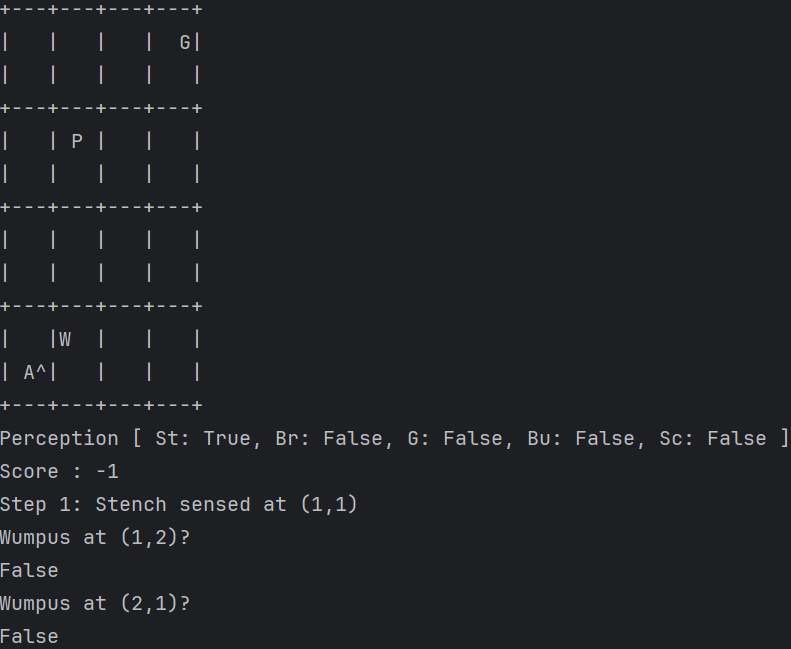

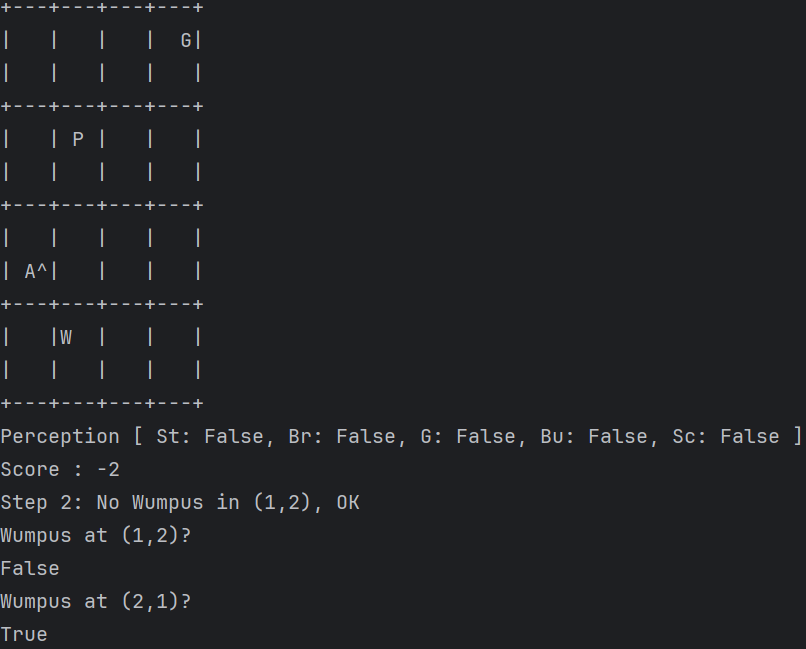

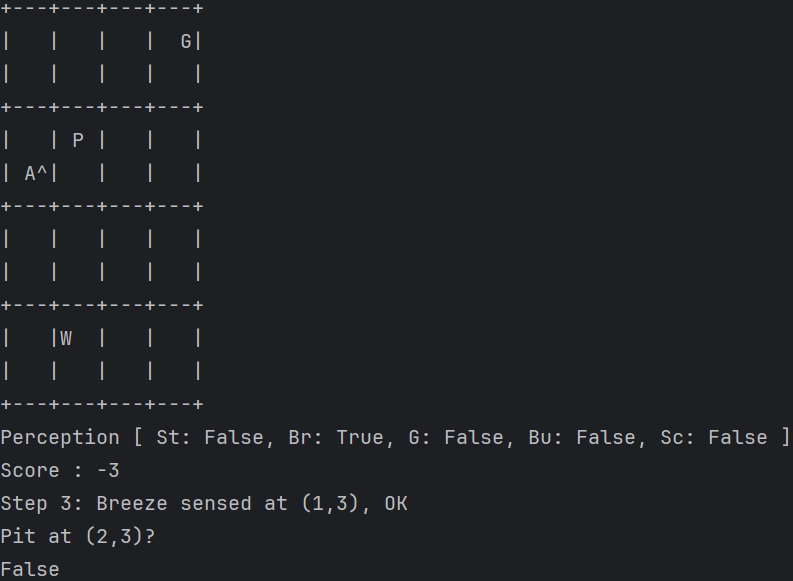

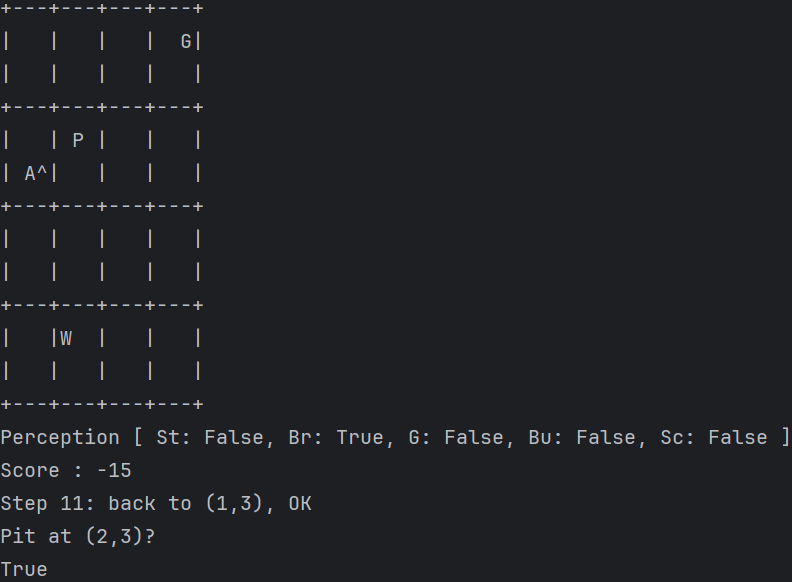